In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
np.random.seed(42)


data = pd.read_csv('data/GenreClassData_30s.txt', sep='\t')
data["TrackID"] = range(len(data))

# Split the data into training and testing sets
train = data[data['Type'] == 'Train']
test = data[data['Type'] == 'Test']


#all_features = [col for col in data.columns if col not in ['Track ID','TrackID', 'File', 'GenreID', 'Genre', 'Type']]
features = [
    'zero_cross_rate_mean','zero_cross_rate_std','rmse_mean','rmse_var',
    'spectral_centroid_mean','spectral_centroid_var','spectral_bandwidth_mean','spectral_bandwidth_var',
    'spectral_rolloff_mean','spectral_rolloff_var','spectral_contrast_mean','spectral_contrast_var',
    'spectral_flatness_mean','spectral_flatness_var',
    'chroma_stft_7_mean','tempo',
    'mfcc_1_mean','mfcc_2_mean','mfcc_3_mean','mfcc_4_mean','mfcc_5_mean','mfcc_6_mean',
    'mfcc_2_std','mfcc_3_std','mfcc_4_std','mfcc_5_std', 'mfcc_7_std'
]

targets = ['Genre']

In [2]:
class Cluster:
    def __init__(self, mean, covariance, datapoints, accumulated_distance=0.0, inv_covariance=None):
        self.mean = mean
        self.covariance = covariance
        self.datapoints = datapoints
        self.accumulated_distance = accumulated_distance
        self.inv_covariance = inv_covariance

In [3]:
## Helper functions


def euclidean_distance(datapoint, mu):
    '''
    Compute the Euclidean distance between two vectors.
    '''
    distance = 0
    for i in range(len(datapoint)):
        distance += (datapoint[i] - mu[i]) ** 2
    return np.sqrt(distance)

def calculate_mean(X):
    '''
    Compute the mean vector of the given data.
    '''
    n_samples, n_features = X.shape
    accumalated_sum = np.zeros(n_features)
    for k in range(n_samples):
        accumalated_sum += X[k][:]
    
    mean = accumalated_sum/n_samples
    return mean

def calculate_covariance(X, mean):
    '''
    Compute the covariance matrix for the given data.
    '''
    n_samples, n_features = X.shape
    covariance_matrix = np.zeros((n_features, n_features))
    for k in range(n_samples):
        diff = X[k] - mean
        covariance_matrix += np.outer(diff, diff)

    covariance_matrix /= n_samples
    return covariance_matrix

def mahalanobis_distance(x, mean, cov):
    '''
    Calculate the mahalanobis distance between
    '''
    try:
        inv_cov = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        cov += np.eye(cov.shape[0]) * 1e-6
        inv_cov = np.linalg.inv(cov)

    diff = x - mean
    return diff.T @ inv_cov @ diff


def calculate_accumulated_distance(X, mean, covariance):
    '''
    Calculate the sum of Mahalanobis distances of all points in X to the mean.
    '''
    n_samples, _ = X.shape
    accumulated_distance = 0.0

    for k in range(n_samples):
        distance = mahalanobis_distance(X[k], mean, covariance)
        accumulated_distance += distance

    return accumulated_distance  # total D


def find_cluster_to_split(cluster_dict, current_class):
    '''
    Find the cluster with the largest accumulated distance for splitting.
    '''
    clusters = cluster_dict[current_class]
    if(len(clusters) == 1):
        return clusters[0]
    else:
        
        cluster_to_split = clusters[0]
        for i in range(1, len(clusters)):
            if(clusters[i].accumulated_distance > cluster_to_split.accumulated_distance):
                cluster_to_split = clusters[i] 

    return cluster_to_split

def find_cluster_to_split_points(cluster_dict, current_class):
    """
    Return the cluster in `cluster_dict[current_class]` that has
    the largest number of datapoints.
    """
    
    clusters = cluster_dict[current_class]
    if len(clusters) == 1:
        return clusters[0]
    
    return max(clusters, key=lambda c: len(c.datapoints))
    



def scale_data(X_train, X_test):
    '''
    Compute the mean vector of the given data.
    '''
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()

    means = np.mean(X_train_np, axis=0)
    stds = np.std(X_train_np, axis=0)
    
    X_train_scaled = (X_train_np - means) / stds
    X_test_scaled = (X_test_np - means) / stds
    return X_train_scaled, X_test_scaled

def calculate_accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)


In [4]:
def create_classifier(X_train, y_train, classes, beta):
    """
    Creates a template-based classifier by clustering data for each class.

    Parameters
    ----------
    X_train : pandas.DataFrame or numpy.ndarray
        Training feature data.
    y_train : pandas.Series or numpy.ndarray
        Training labels.
    classes : list
        List of unique class labels.
    beta : float
        Stopping criterion for cluster splitting.

    Returns
    -------
    cluster_dict : dict
        Dictionary mapping class labels to lists of Cluster objects.
    """
    
    # Dictionary mapping class labels to lists of Cluster objects.
    cluster_dict = {}
    for current_class in classes:
        cluster_dict[current_class] = []
        clusters = cluster_dict[current_class]

        class_data = X_train[y_train['Genre'] == current_class].to_numpy()

        # Initial cluster values
        mean = calculate_mean(class_data)
        cov = calculate_covariance(class_data, mean)
        acc_dist = calculate_accumulated_distance(class_data, mean, cov)
        
        cluster_main = Cluster(mean=mean, covariance=cov, datapoints=class_data, accumulated_distance=acc_dist)

        clusters.append(cluster_main)
        we_are_improving = True

        previous_accumulated_distance = 0
        for cluster in clusters:
                previous_accumulated_distance += cluster.accumulated_distance
        
        # Removing this entire while loop increases accuracy...
        while we_are_improving: 
            current_accumulated_distance = 0

            splitting_cluster = find_cluster_to_split_points(cluster_dict, current_class)
            mu = splitting_cluster.mean
            cov = splitting_cluster.covariance
            
            # Use the variance of the splitting cluster to generate a noise vector
            stds = np.sqrt(np.diag(cov))
            scale_factor = 1.0
            w = scale_factor * np.random.uniform(-stds, stds)

            # Altered mean for the new two clusters
            mu_1 = mu + w
            mu_2 = mu - w

            trial_clusters = [c for c in clusters if c is not splitting_cluster]
            trial_clusters.append(Cluster(mean=mu_1, covariance=cov, datapoints=[]))
            trial_clusters.append(Cluster(mean=mu_2, covariance=cov, datapoints=[]))

            # Assign all datapoints to the closest of the trial clusters
            for cluster in trial_clusters:
                cluster.datapoints = []
            for x in class_data:
                closest_cluster = trial_clusters[0]
                closest_distance = euclidean_distance(x, closest_cluster.mean)
                for c in range(1, len(trial_clusters)):
                    if euclidean_distance(x, trial_clusters[c].mean) < closest_distance:
                        closest_distance = euclidean_distance(x, trial_clusters[c].mean)
                        closest_cluster = trial_clusters[c]
                closest_cluster.datapoints.append(x)
        
            
            # Recalculate means/covs/accumulated_distance for trial clusters
            current_accumulated_distance = 0
            for cluster in trial_clusters:
                if len(cluster.datapoints) == 0:
                    continue
                X_cluster = np.array(cluster.datapoints)
                cluster.mean = calculate_mean(X_cluster)
                cluster.covariance = calculate_covariance(X_cluster, cluster.mean)
                cluster.accumulated_distance = calculate_accumulated_distance(X_cluster, cluster.mean, cluster.covariance)
                current_accumulated_distance += cluster.accumulated_distance

            # Only commit the split if it improved
            if current_accumulated_distance < beta * previous_accumulated_distance:
                clusters.clear()
                clusters.extend(trial_clusters)
                previous_accumulated_distance = current_accumulated_distance
            else:
                we_are_improving = False



    return cluster_dict


In [5]:

X_train_unscaled, y_train = train[features], train[targets]
X_test_unscaled, y_test = test[features], test[targets]
X_train_scaled, X_test_scaled = scale_data(X_train_unscaled,X_test_unscaled)

X_train = pd.DataFrame(X_train_scaled, columns=X_train_unscaled.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_unscaled.columns)

classes = y_train['Genre'].unique()
#print(f"Classes: {classes}")
beta = 0.99
cluster_dict = create_classifier(X_train, y_train, classes, beta)

In [6]:
for i in classes:
    print(f"{i} has {len(cluster_dict[i])} clusters")

pop has 1 clusters
metal has 1 clusters
disco has 1 clusters
blues has 1 clusters
reggae has 1 clusters
classical has 1 clusters
rock has 1 clusters
hiphop has 1 clusters
country has 1 clusters
jazz has 1 clusters


In [7]:
def plot_clusters_for_class(class_name, cluster_dict, X_train, y_train):
    class_data = X_train[y_train['Genre'] == class_name]

    #Reduces to 2 dimensions for plotting
    pca = PCA(n_components=2) 
    class_data_2d = pca.fit_transform(class_data)

    # Transform cluster-means
    cluster_means_2d = [pca.transform(cluster.mean.reshape(1, -1))[0] for cluster in cluster_dict[class_name]]

    # Plot datapunktene
    plt.figure(figsize=(8, 6))
    plt.scatter(class_data_2d[:, 0], class_data_2d[:, 1], c='lightgray', label='Data points')

    # Plot cluster sentrene
    for idx, mean_2d in enumerate(cluster_means_2d):
        plt.scatter(mean_2d[0], mean_2d[1], c='red', marker='X', s=100, label=f'Cluster' if idx == 0 else "")
    
    plt.title(f"Clusters for class '{class_name}'")
    plt.legend()
    plt.grid(True)
    plt.show()


c:\Users\knutr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


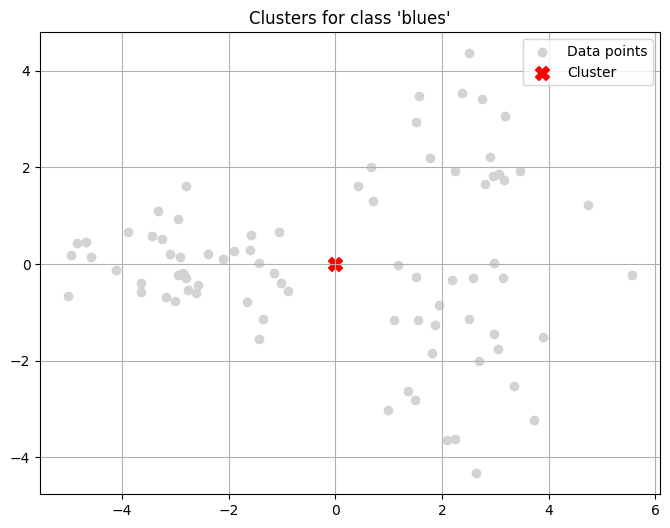

c:\Users\knutr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


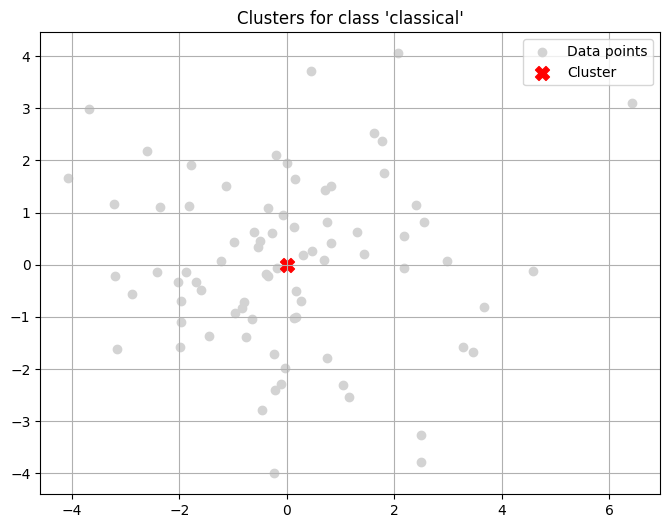

c:\Users\knutr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


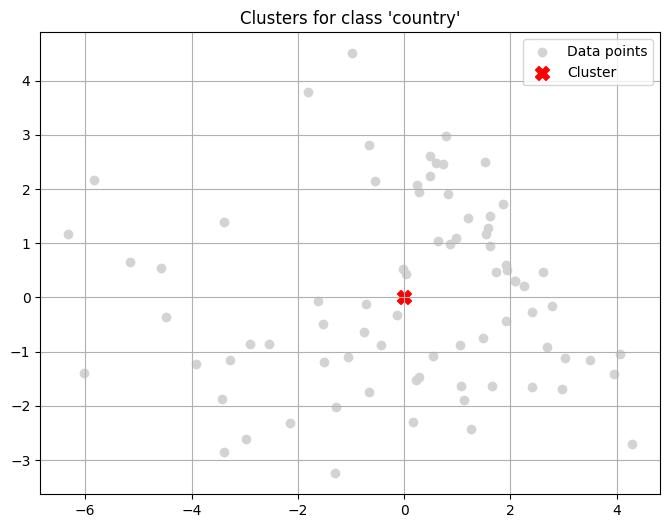

c:\Users\knutr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


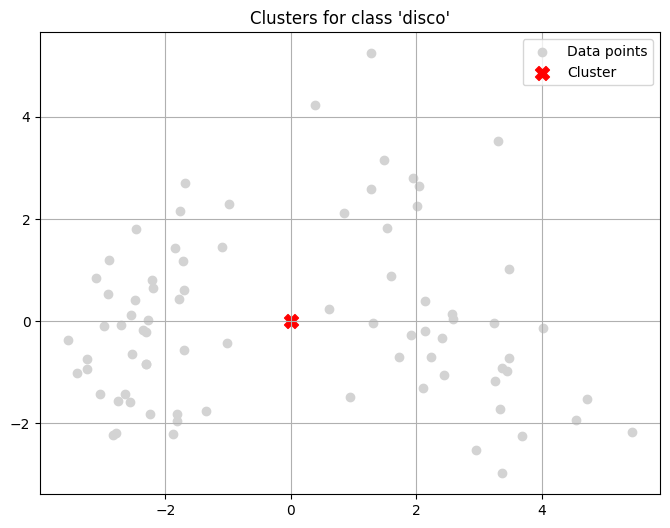

c:\Users\knutr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


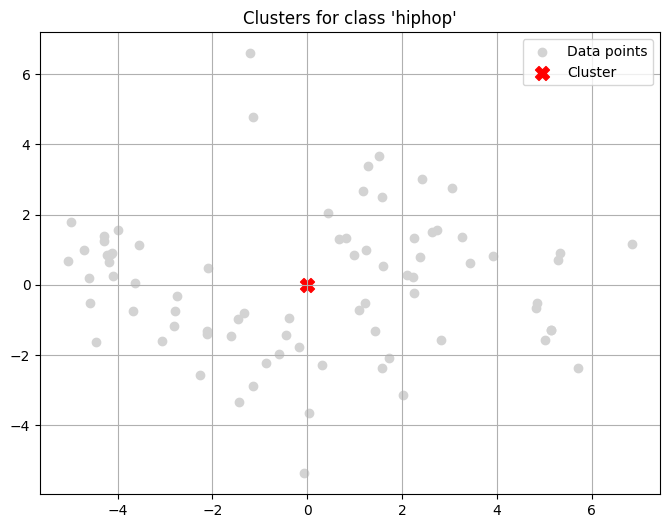

c:\Users\knutr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


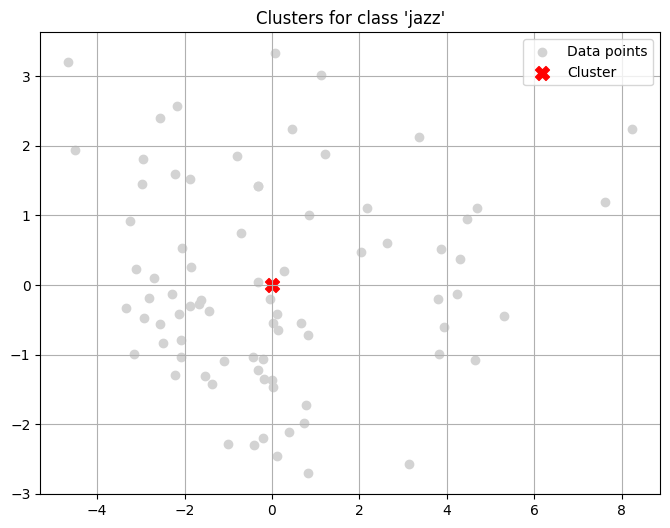

c:\Users\knutr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


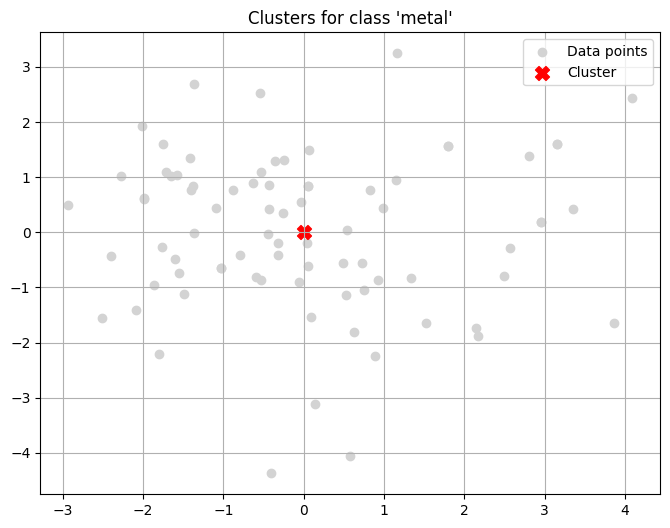

c:\Users\knutr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


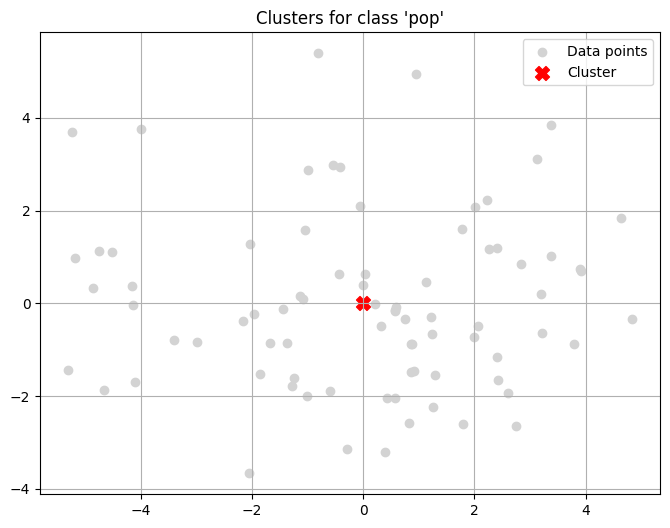

In [8]:
plot_clusters_for_class('blues', cluster_dict, X_train, y_train)
plot_clusters_for_class('classical', cluster_dict, X_train, y_train)
plot_clusters_for_class('country', cluster_dict, X_train, y_train)
plot_clusters_for_class('disco', cluster_dict, X_train, y_train)
plot_clusters_for_class('hiphop', cluster_dict, X_train, y_train)
plot_clusters_for_class('jazz', cluster_dict, X_train, y_train)
plot_clusters_for_class('metal', cluster_dict, X_train, y_train)
plot_clusters_for_class('pop', cluster_dict, X_train, y_train)

In [ ]:
def classify_sample(x,cluster_dict):
    best_distance = float('inf')
    predicted_class = ''

    for class_name, clusters in cluster_dict.items(): # For key, values in dict
        for cluster in clusters:
            d = mahalanobis_distance(x,cluster.mean, cluster.covariance)
            if d < best_distance:
                best_distance = d
                predicted_class = class_name
    return predicted_class
    

predicted_label = classify_sample(X_test.iloc[0],cluster_dict)
print(f"Predicted label: {predicted_label}. True label: {y_test.iloc[0]['Genre']}")

Predicted label: pop. True label: pop


In [10]:
def predict(X_test, cluster_dict):
    predictions = []
    for x in X_test.to_numpy():
        label = classify_sample(x, cluster_dict)
        predictions.append(label)
    return predictions

In [11]:


y_test_true = y_test['Genre'].to_numpy()
y_pred = predict(X_test, cluster_dict)

accuracy = calculate_accuracy(y_test_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.7020
